# Trotterization

In [1]:
import qiskit
from qiskit import *
import math
import numpy as np

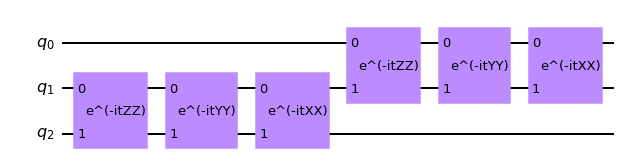

In [2]:
def qc_ezz(t):
    qc = QuantumCircuit(2, name = 'e^(-itZZ)')
    qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1) 
    return qc
def qc_exx(t):
    qc = QuantumCircuit(2, name = 'e^(-itXX)')
    qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1])
    return qc
def qc_eyy(t):
    qc = QuantumCircuit(2, name = 'e^(-itYY)')
    qc.sdg([0,1]); qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1]); qc.s([0,1])
    return qc
def qc_Bj(t):
    qc = QuantumCircuit(3, name = 'B_j')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    return qc
qc_Bj_ = qc_Bj(math.pi/2); qc_Bj_.draw(output='mpl')

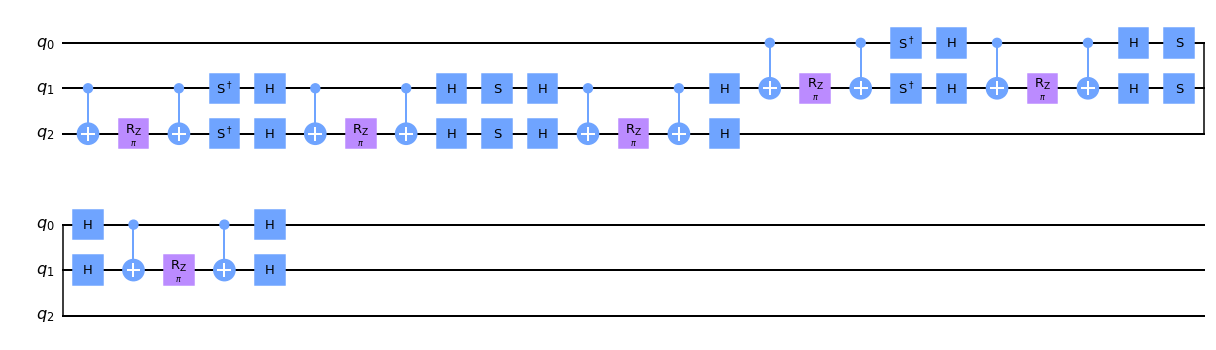

In [3]:
qc_Bj_.decompose().draw(output='mpl')

Each Trotter step is comprised of this circuit. And we need at least 6 Trotter steps to reach the minimum value of state preparation fidelity (theorectically).

In [5]:
nshots = 8192
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_jakarta')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [18]:
# for error mitigation
qr = QuantumRegister(7)
qubit_list = [5,3,1] # os qubits para os quais aplicaremos calibracao de medidas
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)
job = qiskit.execute(meas_calibs, backend = device, shots = nshots); job_monitor(job)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

Job Status: job is queued (1201)  

KeyboardInterrupt: 

## With simulated noise

In [6]:
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map

In [8]:
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]);
psi0 = np.kron(ket0, np.kron(ket1, ket1)) # initial state to be used for computing the fidelity
t = math.pi
for j in range(0, 10): # Trotter steps
    # quantum circuit
    qc = QuantumCircuit(7)
    qc.x([5, 3]) # prepares the initial state
    qc_Bj_ = qc_Bj(t/(j+1))
    for k in range(0, j+1):
        qc.append(qc_Bj_, [5, 3, 1])
    qstc = state_tomography_circuits(qc, [5, 3, 1])
    # simulation
    job_sim = execute(qstc, backend = simulator, shots = nshots)
    qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
    rho_sim = qstf_sim.fit(method = 'lstsq')
    F_sim = quantum_info.state_fidelity(psi0, rho_sim)
    # simulation with simulated noise
    job_exp = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
                      basis_gates = basis_gates, coupling_map = coupling_map)
    qstf_exp = StateTomographyFitter(job_exp.result(), qstc)
    rho_exp = qstf_exp.fit(method = 'lstsq')
    F_exp = quantum_info.state_fidelity(psi0, rho_exp)
    print('No. passos=', j+1, ',F_sim=', F_sim, ',F_exp=', F_exp)

No. passos= 1 ,F_sim= 0.9963522384695273 ,F_exp= 0.8902619858065385
No. passos= 2 ,F_sim= 0.9947608487646025 ,F_exp= 0.730313578759523
No. passos= 3 ,F_sim= 0.07815570017120493 ,F_exp= 0.08717358803081118
No. passos= 4 ,F_sim= 0.0001789585225619678 ,F_exp= 0.043981381846554514
No. passos= 5 ,F_sim= 0.2554298102594595 ,F_exp= 0.17776857241743307
No. passos= 6 ,F_sim= 0.5720959137628336 ,F_exp= 0.2869360828027298
No. passos= 7 ,F_sim= 0.7553962988952234 ,F_exp= 0.32314953969740984
No. passos= 8 ,F_sim= 0.856058137677428 ,F_exp= 0.32258318687283505
No. passos= 9 ,F_sim= 0.9067841142073211 ,F_exp= 0.315328926938061
No. passos= 10 ,F_sim= 0.9391762751736303 ,F_exp= 0.29375866446286564


## With simulated noise and error mitigation

In [9]:
# for error mitigation
qr = QuantumRegister(7)
qubit_list = [5,3,1] # the qubits on which we shall apply error mitigation
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)
job_cal = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model, 
                  basis_gates = basis_gates, coupling_map = coupling_map)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

In [10]:
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
psi0 = np.kron(ket0, np.kron(ket1, ket1)) # initial state to be used for computing the fidelity
t = math.pi
for j in range(0, 10): # Trotter steps
    # quantum circuit
    qc = QuantumCircuit(7)
    qc.x([5, 3]) # prepares the initial state
    qc_Bj_ = qc_Bj(t/(j+1))
    for k in range(0, j+1):
        qc.append(qc_Bj_, [5, 3, 1])
    qstc = state_tomography_circuits(qc, [5, 3, 1])
    # simulation
    job_sim = execute(qstc, backend = simulator, shots = nshots)
    qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
    rho_sim = qstf_sim.fit(method = 'lstsq')
    F_sim = quantum_info.state_fidelity(psi0, rho_sim)
    # simulation with simulated noise and error mitigation
    job_exp = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
                      basis_gates = basis_gates, coupling_map = coupling_map)
    mitigated_results = meas_fitter.filter.apply(job_exp.result())
    qstf_exp = StateTomographyFitter(mitigated_results, qstc)
    rho_exp = qstf_exp.fit(method = 'lstsq')
    F_exp = quantum_info.state_fidelity(psi0, rho_exp)
    print('No. passos=', j+1, ',F_sim=', F_sim, ',F_exp=', F_exp)

No. passos= 1 ,F_sim= 0.993584062782807 ,F_exp= 0.9944334009373328
No. passos= 2 ,F_sim= 0.9961568945773354 ,F_exp= 0.8210299511515393
No. passos= 3 ,F_sim= 0.07741402901794962 ,F_exp= 0.09105479051651923
No. passos= 4 ,F_sim= 0.000294433386341252 ,F_exp= 0.03959667142545146
No. passos= 5 ,F_sim= 0.2558980804126396 ,F_exp= 0.18750282857972903
No. passos= 6 ,F_sim= 0.5701045548852492 ,F_exp= 0.31198753510033883
No. passos= 7 ,F_sim= 0.7557034446187959 ,F_exp= 0.35477312578509096
No. passos= 8 ,F_sim= 0.8534659455932252 ,F_exp= 0.3660980569379751
No. passos= 9 ,F_sim= 0.9079181429886654 ,F_exp= 0.3427865351410006
No. passos= 10 ,F_sim= 0.9395362544254358 ,F_exp= 0.3187275247855099


We see that, in this case, the application of error mitigation is of little help, since it improves only a little bit the results.

# With simulated noise, error mitigation, and symmetry transformations

Using $B_{j} = \Big(e^{iZ\phi}\otimes e^{iZ\phi}\otimes I\Big)\Big(e^{-iH_{xxx}^{(2)}t/j}\otimes I\Big)\Big(e^{-iZ\phi}\otimes e^{-iZ\phi}\otimes I\Big)\Big(I\otimes e^{iZ\theta}\otimes e^{iZ\theta}\Big)\Big(I\otimes e^{-iH_{xxx}^{(2)}t/j}\Big)\Big(I\otimes e^{-iZ\theta}\otimes e^{-iZ\theta}\Big)$

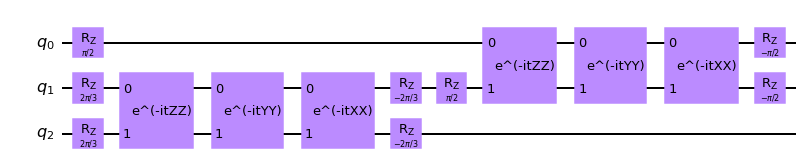

In [32]:
def qc_Bj_zz(t, th, ph):
    qc = QuantumCircuit(3, name = 'B_j')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.rz(2*th, [1,2])
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.rz(-2*th, [1,2])
    qc.rz(2*ph, [0,1])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    qc.rz(-2*ph, [0,1])
    return qc
qc_Bj_zz_ = qc_Bj_zz(math.pi/2, math.pi/3, math.pi/4); qc_Bj_zz_.draw(output='mpl')